Train and test HybridKAN by Net on iris dataset

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
import sys
import os
sys.path.append(os.path.abspath('..'))
from kans import HybridKANbyNet

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

if os.path.exists('model') == False:
	os.makedirs('model')

cpu


In [2]:
def train(model, train_loader, test_input, test_label, num_epochs=50, save=False, model_name=''):
	print('-'*50)
	print(f'Training {model_name} model...')
	optimizer = optim.Adam(model.parameters(), lr=0.01)
	criterion = nn.CrossEntropyLoss() # Use CrossEntropyLoss for classification
	epoch_losses = []
	epoch_accuracies = []
	bar = tqdm(total=num_epochs)
	start_t = time.time()
	for epoch in range(num_epochs):
		running_loss = 0.0
		model.train()
		for i, (inputs, labels) in enumerate(train_loader):
            # Forward pass
			outputs = model(inputs)
			loss = criterion(outputs, labels)
            
            # Backward and optimize
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
            
            # Record loss
			running_loss += loss.item()
        
        # Print information every certain steps
		epoch_loss = running_loss / len(train_loader)
		epoch_losses.append(epoch_loss)
		epoch_accuracy = test(model, test_input, test_label)
		epoch_accuracies.append(epoch_accuracy)
		bar.set_description(f'{model_name} Epoch {epoch+1}')
		bar.set_postfix(loss=f'{epoch_loss:.4f}', accuracy=f'{epoch_accuracy:.2f}%')
		bar.update(1)
	bar.close()
	end_t = time.time()
	epoch_time = (end_t - start_t) / num_epochs
	print(f'Average Epoch Training Time :{epoch_time}s')
	if save:
		torch.save(model.state_dict(), f'model/{model_name}.pth')
		print(f'Model saved as model/{model_name}.pth')
	return epoch_losses, epoch_accuracies, epoch_time

def test(model, test_input, test_label):
	model.eval()
	with torch.no_grad():
		test_output = model(test_input)
		_, predicted = torch.max(test_output, 1)
		accuracy = (predicted == test_label).sum().item() / test_label.size(0) * 100
	return accuracy

In [3]:
# Generate dataset
iris = load_iris()
X = iris.data
y = iris.target
scaler = StandardScaler()
X = scaler.fit_transform(X) # Standardize the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float64, device=device)
print('train_input size:', X_train.shape)
X_test = torch.tensor(X_test, dtype=torch.float64, device=device)
print('test_input size:', X_test.shape)
y_train = torch.tensor(y_train, dtype=torch.long, device=device)
print('train_label size:', y_train.shape)
y_test = torch.tensor(y_test, dtype=torch.long, device=device)
print('test_label size:', y_test.shape)
dataset = {'train_input': X_train, 'train_label': y_train, 'test_input': X_test, 'test_label': y_test}

# Create data loader
train_dataset = TensorDataset(dataset['train_input'], dataset['train_label'])
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_input size: torch.Size([120, 4])
test_input size: torch.Size([30, 4])
train_label size: torch.Size([120])
test_label size: torch.Size([30])


In [4]:
# Setting of the model: The number of learnable parameters per layer is: input_size * output_size * (p + 1)
layer_sizes = [4,8,3]  # Specify the number of nodes per layer

# b_kan: p = b_grid_count
b_order = 3  # Order of B-spline
b_grid_range = [-1,1]  # Grid range of B-spline
b_grid_count = 6  # Grid count of B-spline

# f_kan: p = frequency_count * 2 + 1
frequency_count = 3  # Frequency count of Fourier series

# g_kan: p = g_grid_count
g_grid_range = [-1,1]  # Grid range of Gaussian radial basis function
g_grid_count = 6 # Grid count of Gaussian radial basis function

# j_kan: p = j_order + 1
j_order = 5  # Order of Jacobi polynomial
alpha = 0.5  # Alpha of Jacobi polynomial
beta = 0.5  # Beta of Jacobi polynomial

# r_kan: p = mole_order + deno_order + 1
mole_order = 3  # Order of numerator
deno_order = 2  # Order of denominator

# t_kan: p = t_order + 1
t_order = 5  # Order of Taylor polynomial

# w_kan: p = wave_num * 3
wave_num = 2  # Number of wavelets
wave_type = 'morlet'  # Type of wavelet

# be_kan: p = be_order + 1
be_order = 5  # Order of Bernstein polynomial
inter_range = [0, 1]  # Interpolation range

In [5]:
# Train and test the models
num_epochs = 50
# hybrid_kan
model = HybridKANbyNet(layer_sizes,
					   ['b_kan', 'f_kan', 'g_kan', 'j_kan', 'r_kan', 't_kan', 'w_kan', 'be_kan'],
					   b_order=b_order, b_grid_range=b_grid_range, b_grid_count=b_grid_count,
					   frequency_count=frequency_count,
					   g_grid_range=g_grid_range, g_grid_count=g_grid_count,
					   j_order=j_order, alpha=alpha, beta=beta,
					   mole_order=mole_order, deno_order=deno_order,
					   t_order=t_order,
					   wave_num=wave_num, wave_type=wave_type,
					   be_order=be_order, inter_range=inter_range
					   ).to(device)
h_epoch_losses, h_epoch_accuracies, h_epoch_time = train(model, train_loader, dataset['test_input'], dataset['test_label'], num_epochs=num_epochs, save=True, model_name='HybridKANbyNet_iris')
model.show_contributions()
del model
torch.cuda.empty_cache()

# b_kan
model = HybridKANbyNet(layer_sizes,
					   ['b_kan']*8,
					   b_order=b_order, b_grid_range=b_grid_range, b_grid_count=b_grid_count
					   ).to(device)
b_epoch_losses, b_epoch_accuracies, b_epoch_time = train(model, train_loader, dataset['test_input'], dataset['test_label'], num_epochs=num_epochs, save=True, model_name='BSplineKAN_iris')
del model
torch.cuda.empty_cache()

# f_kan
model = HybridKANbyNet(layer_sizes,
					   ['f_kan']*8,
					   frequency_count=frequency_count
					   ).to(device)
f_epoch_losses, f_epoch_accuracies, f_epoch_time = train(model, train_loader, dataset['test_input'], dataset['test_label'], num_epochs=num_epochs, save=True, model_name='FourierKAN_iris')
del model
torch.cuda.empty_cache()

# g_kan
model = HybridKANbyNet(layer_sizes,
					   ['g_kan']*8,
					   g_grid_range=g_grid_range, g_grid_count=g_grid_count
					   ).to(device)
g_epoch_losses, g_epoch_accuracies, g_epoch_time = train(model, train_loader, dataset['test_input'], dataset['test_label'], num_epochs=num_epochs, save=True, model_name='GaussianKAN_iris')
del model
torch.cuda.empty_cache()

# j_kan
model = HybridKANbyNet(layer_sizes,
					   ['j_kan']*8,
					   j_order=j_order, alpha=alpha, beta=beta
					   ).to(device)
j_epoch_losses, j_epoch_accuracies, j_epoch_time = train(model, train_loader, dataset['test_input'], dataset['test_label'], num_epochs=num_epochs, save=True, model_name='JacobiKAN_iris')
del model
torch.cuda.empty_cache()

# r_kan
model = HybridKANbyNet(layer_sizes,
					   ['r_kan']*8,
					   mole_order=mole_order, deno_order=deno_order
					   ).to(device)
r_epoch_losses, r_epoch_accuracies, r_epoch_time = train(model, train_loader, dataset['test_input'], dataset['test_label'], num_epochs=num_epochs, save=True, model_name='RationalKAN_iris')
del model
torch.cuda.empty_cache()

# t_kan
model = HybridKANbyNet(layer_sizes,
					   ['t_kan']*8,
					   t_order=t_order
					   ).to(device)
t_epoch_losses, t_epoch_accuracies, t_epoch_time = train(model, train_loader, dataset['test_input'], dataset['test_label'], num_epochs=num_epochs, save=True, model_name='TaylorKAN_iris')
del model
torch.cuda.empty_cache()

# w_kan
model = HybridKANbyNet(layer_sizes,
					   ['w_kan']*8,
					   wave_num=wave_num, wave_type=wave_type
					   ).to(device)
w_epoch_losses, w_epoch_accuracies, w_epoch_time = train(model, train_loader, dataset['test_input'], dataset['test_label'], num_epochs=num_epochs, save=True, model_name='WaveletKAN_iris')
del model
torch.cuda.empty_cache()

# be_kan
model = HybridKANbyNet(layer_sizes,
					   ['be_kan']*8,
					   be_order=be_order, inter_range=inter_range
					   ).to(device)
be_epoch_losses, be_epoch_accuracies, be_epoch_time = train(model, train_loader, dataset['test_input'], dataset['test_label'], num_epochs=num_epochs, save=True, model_name='BernsteinKAN_iris')
del model
torch.cuda.empty_cache()

--------------------------------------------------
Training HybridKANbyNet_iris model...


HybridKANbyNet_iris Epoch 50: 100%|█████████████████████| 50/50 [02:22<00:00,  2.85s/it, accuracy=100.00%, loss=0.0003]


Average Epoch Training Time :2.848620948791504s
Model saved as model/HybridKANbyNet_iris.pth
**Contributions of each basis function:**
Contribution of b_kan: 0.11
Contribution of f_kan: 0.13
Contribution of g_kan: 0.12
Contribution of j_kan: 0.13
Contribution of r_kan: 0.10
Contribution of t_kan: 0.13
Contribution of w_kan: 0.18
Contribution of be_kan: 0.11

--------------------------------------------------
Training BSplineKAN_iris model...


BSplineKAN_iris Epoch 50: 100%|█████████████████████████| 50/50 [02:31<00:00,  3.03s/it, accuracy=100.00%, loss=0.0101]


Average Epoch Training Time :3.0265223026275634s
Model saved as model/BSplineKAN_iris.pth
--------------------------------------------------
Training FourierKAN_iris model...


FourierKAN_iris Epoch 50: 100%|█████████████████████████| 50/50 [02:04<00:00,  2.48s/it, accuracy=100.00%, loss=0.0003]


Average Epoch Training Time :2.4840013647079466s
Model saved as model/FourierKAN_iris.pth
--------------------------------------------------
Training GaussianKAN_iris model...


GaussianKAN_iris Epoch 50: 100%|████████████████████████| 50/50 [01:47<00:00,  2.14s/it, accuracy=100.00%, loss=0.0004]


Average Epoch Training Time :2.144406309127808s
Model saved as model/GaussianKAN_iris.pth
--------------------------------------------------
Training JacobiKAN_iris model...


JacobiKAN_iris Epoch 50: 100%|██████████████████████████| 50/50 [01:49<00:00,  2.18s/it, accuracy=100.00%, loss=0.0002]


Average Epoch Training Time :2.1809512996673583s
Model saved as model/JacobiKAN_iris.pth
--------------------------------------------------
Training RationalKAN_iris model...


RationalKAN_iris Epoch 50: 100%|████████████████████████| 50/50 [01:33<00:00,  1.86s/it, accuracy=100.00%, loss=0.0325]


Average Epoch Training Time :1.8622680282592774s
Model saved as model/RationalKAN_iris.pth
--------------------------------------------------
Training TaylorKAN_iris model...


TaylorKAN_iris Epoch 50: 100%|██████████████████████████| 50/50 [01:15<00:00,  1.51s/it, accuracy=100.00%, loss=0.0027]


Average Epoch Training Time :1.5104477214813232s
Model saved as model/TaylorKAN_iris.pth
--------------------------------------------------
Training WaveletKAN_iris model...


WaveletKAN_iris Epoch 50: 100%|██████████████████████████| 50/50 [02:15<00:00,  2.72s/it, accuracy=96.67%, loss=0.0001]


Average Epoch Training Time :2.7198708343505857s
Model saved as model/WaveletKAN_iris.pth
--------------------------------------------------
Training BernsteinKAN_iris model...


BernsteinKAN_iris Epoch 50: 100%|███████████████████████| 50/50 [01:45<00:00,  2.12s/it, accuracy=100.00%, loss=0.0449]

Average Epoch Training Time :2.117796244621277s
Model saved as model/BernsteinKAN_iris.pth


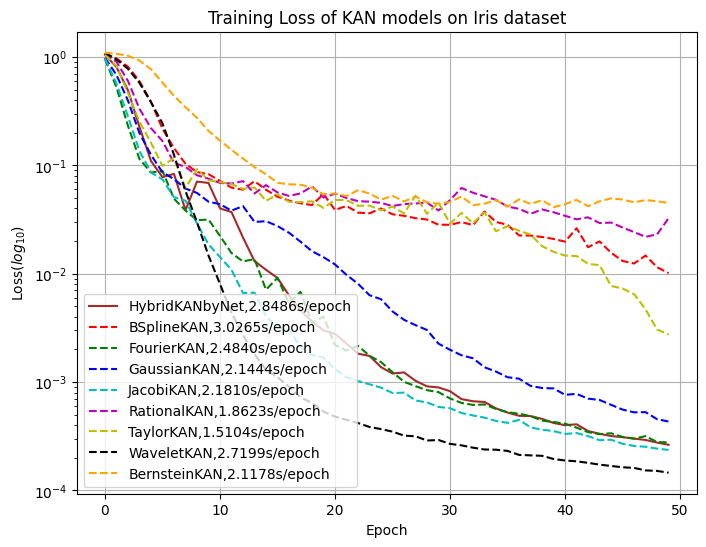

In [6]:
# Plot the loss curve
plt.figure(figsize=(8,6))
plt.plot(h_epoch_losses, label=f'HybridKANbyNet,{h_epoch_time:.4f}s/epoch', color='brown')
plt.plot(b_epoch_losses, label=f'BSplineKAN,{b_epoch_time:.4f}s/epoch', color='r', linestyle='dashed')
plt.plot(f_epoch_losses, label=f'FourierKAN,{f_epoch_time:.4f}s/epoch', color='g', linestyle='dashed')
plt.plot(g_epoch_losses, label=f'GaussianKAN,{g_epoch_time:.4f}s/epoch', color='b', linestyle='dashed')
plt.plot(j_epoch_losses, label=f'JacobiKAN,{j_epoch_time:.4f}s/epoch', color='c', linestyle='dashed')
plt.plot(r_epoch_losses, label=f'RationalKAN,{r_epoch_time:.4f}s/epoch', color='m', linestyle='dashed')
plt.plot(t_epoch_losses, label=f'TaylorKAN,{t_epoch_time:.4f}s/epoch', color='y', linestyle='dashed')
plt.plot(w_epoch_losses, label=f'WaveletKAN,{w_epoch_time:.4f}s/epoch', color='k', linestyle='dashed')
plt.plot(be_epoch_losses, label=f'BernsteinKAN,{be_epoch_time:.4f}s/epoch', color='orange', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss($log_{10}$)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.title('Training Loss of KAN models on Iris dataset')
plt.show()

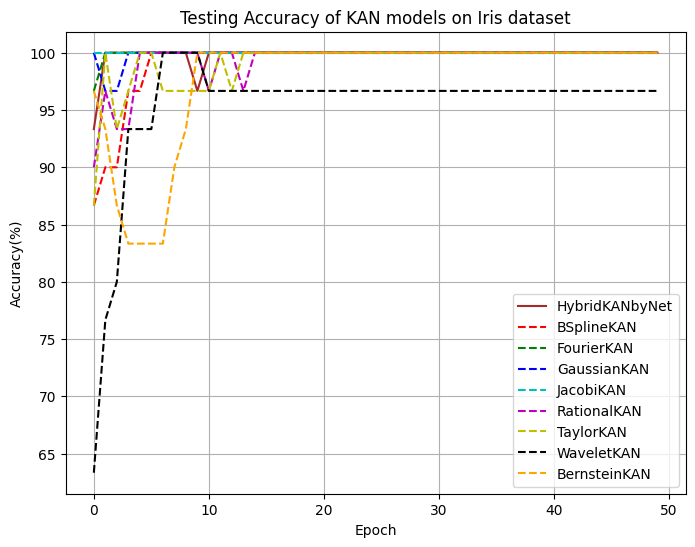

In [7]:
# Plot the accuracy curve
plt.figure(figsize=(8,6))
plt.plot(h_epoch_accuracies, label=f'HybridKANbyNet', color='brown')
plt.plot(b_epoch_accuracies, label=f'BSplineKAN', color='r', linestyle='dashed')
plt.plot(f_epoch_accuracies, label=f'FourierKAN', color='g', linestyle='dashed')
plt.plot(g_epoch_accuracies, label=f'GaussianKAN', color='b', linestyle='dashed')
plt.plot(j_epoch_accuracies, label=f'JacobiKAN', color='c', linestyle='dashed')
plt.plot(r_epoch_accuracies, label=f'RationalKAN', color='m', linestyle='dashed')
plt.plot(t_epoch_accuracies, label=f'TaylorKAN', color='y', linestyle='dashed')
plt.plot(w_epoch_accuracies, label=f'WaveletKAN', color='k', linestyle='dashed')
plt.plot(be_epoch_accuracies, label=f'BernsteinKAN', color='orange', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.grid(True)
plt.legend()
plt.title('Testing Accuracy of KAN models on Iris dataset')
plt.show()